In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
import json
import requests
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from scipy import stats
from bokeh.models import NumeralTickFormatter

output_notebook()
sns.set_theme(style="whitegrid")

Loading BokehJS ...

Az adatok betöltése

In [119]:
europe_df = pd.read_csv(r"C:./beadando_adatok/euro_petrol.csv")
hungary_df = pd.read_csv(r"C:./beadando_adatok/95_petrol_hu.csv")
hungary_df.columns = ["Dátum", "Magyar_Forint", "Régió_Forint", "Szomszédos_Forint"]
hungary_df["Dátum"] = pd.to_datetime(hungary_df["Dátum"])

Árfolyam átváltás(Forint -> Euró)

In [120]:
HUF_EUR = 400
hungary_df["Magyar_EUR"] = hungary_df["Magyar_Forint"] / HUF_EUR
hungary_df["Régió_EUR"] = hungary_df["Régió_Forint"] / HUF_EUR
hungary_df["Szomszédos_EUR"] = hungary_df["Szomszédos_Forint"] / HUF_EUR

Kiugró érték vizsgálat

In [121]:
z_scores = np.abs(stats.zscore(hungary_df["Magyar_EUR"]))
outliers = hungary_df[z_scores > 1.75]

print("\n Kiugró értékek Magyarországon(EUR):")
print(outliers[["Dátum", "Magyar_EUR"]])
max_row = hungary_df.loc[hungary_df["Magyar_EUR"].idxmax()]
min_row = hungary_df.loc[hungary_df["Magyar_EUR"].idxmin()]
print(f"\n Legmagasabb ár: {max_row["Magyar_EUR"]} EUR ({max_row["Dátum"]})")
print(f"\n Legalacsonyabb ár: {min_row["Magyar_EUR"]} EUR ({min_row["Dátum"]})")


 Kiugró értékek Magyarországon(EUR):
        Dátum  Magyar_EUR
1  2023-01-09      1.6425
19 2023-05-15      1.3900
20 2023-05-22      1.3925
37 2023-09-18      1.6400
38 2023-09-25      1.6475
50 2023-12-18      1.3800
51 2023-12-25      1.3650

 Legmagasabb ár: 1.6475 EUR (2023-09-25 00:00:00)

 Legalacsonyabb ár: 1.365 EUR (2023-12-25 00:00:00)


Magyarország heti átlagos 95-ös benzin árfolyamának az összehasonlítása a szomszédos és Közép Európa országaival (Forrás: https://www.ksh.hu/s/en/experimental-statistics/publications/motor-fuel-price-statistics-2025-05-06/)

In [122]:

if "Dátum_str" not in hungary_df.columns:
	hungary_df["Dátum_str"] = hungary_df["Dátum"].dt.strftime("%Y-%m-%d")
source = ColumnDataSource(hungary_df)

p = figure(title="Magyarország vs Régióbeli és Szomszédos országok (EUR)", x_axis_type="datetime", width=900, height=400)
p.line("Dátum", "Magyar_EUR", source=source, legend_label="Magyarország", color="blue", line_width=2)
p.line("Dátum", "Régió_EUR", source=source, legend_label="Régió", color="green", line_dash="dashed", line_width=2)
p.line("Dátum", "Szomszédos_EUR", source=source, legend_label="Szomszédos országok", color="red", line_dash="dotted", line_width=2)

p.add_tools(HoverTool(tooltips=[("Dátum", "@Dátum_str"), ("Ár", "@Magyar_EUR")]))
p.legend.location = "top_left"
p.xaxis.axis_label = "Dátum"
p.yaxis.axis_label = "€/Liter"

show(p)

Korrelációs mátrix a magyar és a szomszédos illetve régióbeli országok adataival

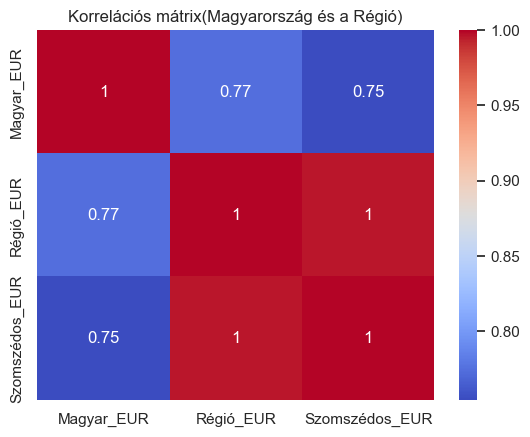

In [123]:
corr = hungary_df[["Magyar_EUR", "Régió_EUR", "Szomszédos_EUR"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Korrelációs mátrix(Magyarország és a Régió)")
plt.show()

Az európai országok 95-ös benzin árfolyamainak a legfrisebb adatai az Eurostat szerint (Forrás:https://energy.ec.europa.eu/data-and-analysis/weekly-oil-bulletin_en#taxes-on-petroleum-products)

In [124]:
df = europe_df.iloc[1:-2].copy()
fuel_data = df[['in EUR', 'Euro-super 95  (I)']].copy()
fuel_data.columns = ['Country', 'Price_per_1000L']
fuel_data['Price_per_1000L'] = fuel_data['Price_per_1000L'].str.replace('.', '', regex=False)  
fuel_data['Price_per_1000L'] = fuel_data['Price_per_1000L'].str.replace(',', '.', regex=False)
fuel_data = fuel_data[fuel_data['Country'] != 'on: 28/04/2025 per -']
fuel_data['Price_per_1000L'] = pd.to_numeric(fuel_data['Price_per_1000L'], errors='coerce')
fuel_data.dropna(inplace=True)

fuel_data['Price_per_L'] = fuel_data['Price_per_1000L']


source = ColumnDataSource(fuel_data)

p = figure(x_range=fuel_data['Country'], height=500, title="Euro-super 95 Prices (per Litre)",
           toolbar_location="above", tools="pan,wheel_zoom,box_zoom,reset,hover", tooltips=[
               ("Country", "@Country"),
               ("Price (EUR/L)", "@Price_per_L{0.000}")
           ])

p.vbar(x='Country', top='Price_per_L', width=0.8, source=source, color="steelblue")
p.xaxis.major_label_orientation = 1.2
p.yaxis.axis_label = "Price (EUR per litre)"
p.yaxis.formatter = NumeralTickFormatter(format="0.00")

show(p)

Európa országainak benzinár eloszlása térképen

In [127]:
df = pd.read_csv(r"C:./beadando_adatok/euro_petrol.csv").drop(index=0)
df.columns = [
    "country", "euro_super_95", "diesel", "heating_gas_oil",
    "heavy_fuel_oil_low_sulphur", "heavy_fuel_oil_high_sulphur", "lpg"
]
df["euro_super_95"] = (
    df["euro_super_95"]
    .str.replace(".", "", regex=False)
    .str.replace(",", ".", regex=False)
    .str.strip()
)
df["euro_super_95"] = pd.to_numeric(df["euro_super_95"], errors="coerce")
df = df.dropna(subset=["euro_super_95"])

url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json"
geojson = requests.get(url).json()

df["country"] = df["country"].str.strip().str.title()

geojson_dict = geojson['features']

for feature in geojson_dict:
    country_name = feature['properties']['name']
    price = df[df['country'] == country_name]['euro_super_95'].values
    if len(price) > 0:
        feature['properties']['price'] = price[0]
    else:
        feature['properties']['price'] = 'N/A'

m = folium.Map(location=[54, 15], zoom_start=4)

choropleth = folium.Choropleth(
    geo_data=geojson,
    name='choropleth',
    data=df,
    columns=['country', 'euro_super_95'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0,
    legend_name='Euro-super 95 ár (€/liter)',
).add_to(m)

folium.GeoJson(
    geojson,
    name="geojson",
    tooltip=folium.GeoJsonTooltip(
        fields=["name", "price"],
        aliases=["Ország:", "Euro-super 95 ár:"],
        localize=True,
        sticky=False,
        labels=False
    )
).add_to(m)

m 
